In [1]:
# Imports
import random
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import model
from keijzer_exogan import *

# initialize random seeds
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks')


"""
Local variables
"""
workers = 0 # Number of workers for dataloader, 0 when to_vram is enabled
batch_size = 1 # using one image ofcourse
image_size = 32
nz = 100 # size of latent vector
n_iters = 25*10**3 # number of iterations to do for inpainting
torch.backends.cudnn.benchmark=True # Uses udnn auto-tuner to find the best algorithm to use for your hardware, speeds up training by almost 50%

lr = 1e-1
lamb1 = 1e3 #1e4
lamb2 = 1 # 1 , total_loss = lamb1*loss_context + lamb2*loss_perceptual

lr_G = 2e-4
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
selected_gpus = [3] # Number of GPUs available. Use 0 for CPU mode.

In [2]:
path = '/datb/16011015/ExoGAN_data/selection//' #notice how you dont put the last folder in here...

images = np.load(path+'last_chunks_25_percent_images_v4.npy').astype('float32')

len(images)

1250000

In [3]:
print('Batch size: ', batch_size)


# Number of training epochs

# Learning rate for optimizers
ngpu = len(selected_gpus)
print('Number of GPUs used: ', ngpu)


"""
Load data and prepare DataLoader
"""
shuffle = True

if shuffle:
    np.random.shuffle(images) # shuffles the images

images = images[:3000] # 1200 should take ~ 1 hour
#images = images[:int(len(images)*0.005)]
print('Number of images: ', len(images))

Batch size:  1
Number of GPUs used:  1
Number of images:  3000


In [4]:
dataset = numpy_dataset(data=images, to_vram=True) # to_vram pins it to all GPU's
#dataset = numpy_dataset(data=images, to_vram=True, transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # to_vram pins it to all GPU's

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=False)

"""
Load and setup models
"""
# Initialize cuda
device = torch.device("cuda:"+str(selected_gpus[0]) if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load models, set to evaluation mode since training is not needed (this also allows batchsize 1 to work with batchnorm2d layers)
netG = model.Generator(ngpu).eval().to(device)
netD = model.Discriminator(ngpu).eval().to(device)

# Apply weights
print('Loading weights...')
try:
    # Load saved weights
    netG.load_state_dict(torch.load('gan_data//weights//netG_state_dict0_v4_test', map_location=device)) #net.module..load_... for parallel model , net.load_... for single gpu model
    netD.load_state_dict(torch.load('gan_data//weights//netD_state_dict0_v4_test', map_location=device))
except:
    print('Could not load saved weights.')
    sys.exit()





"""
Define input training stuff (fancy this up)
"""
G = netG
D = netD
z = torch.randn(1, nz, 1, 1, requires_grad=True, device=device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, device_ids=selected_gpus, output_device=device)
    D = nn.DataParallel(D, device_ids=selected_gpus, output_device=device)
    #z = nn.DataParallel(z, device_ids=selected_gpus, output_device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # should be sgd
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

print('done')

Loading weights...
done


# Show generated images

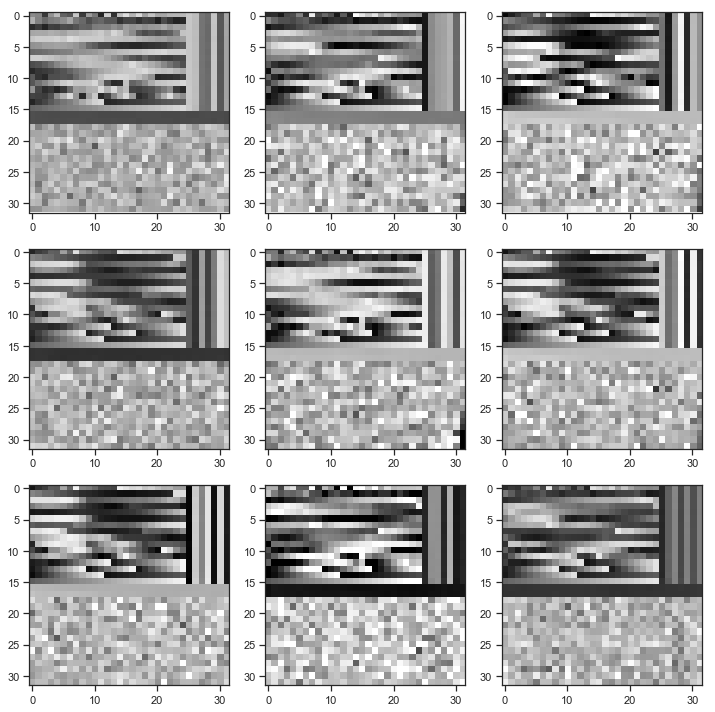

In [ ]:
from sklearn.preprocessing import MinMaxScaler

z_tests = [torch.randn(1, nz, 1, 1, device=device) for _ in range(9)]

plt.figure(figsize=(10,10))
for i in range(9):
    img = G(z_tests[i]).detach().cpu()[0, 0, :, :]
    plt.subplot(3,3,i+1)
    #scaler = MinMaxScaler((0, 1.2))
    #img = scaler.fit_transform(img)
    plt.imshow(img, cmap='gray', vmin=-1.2, vmax=1.2)
    #plt.imshow(img, cmap='gray')

plt.tight_layout()

In [ ]:
img.min(), img.max(), img.mean(), img.std()

(tensor(-1.0222), tensor(1.3806), tensor(0.1106), tensor(0.5604))

## Make sure Z is different for each image

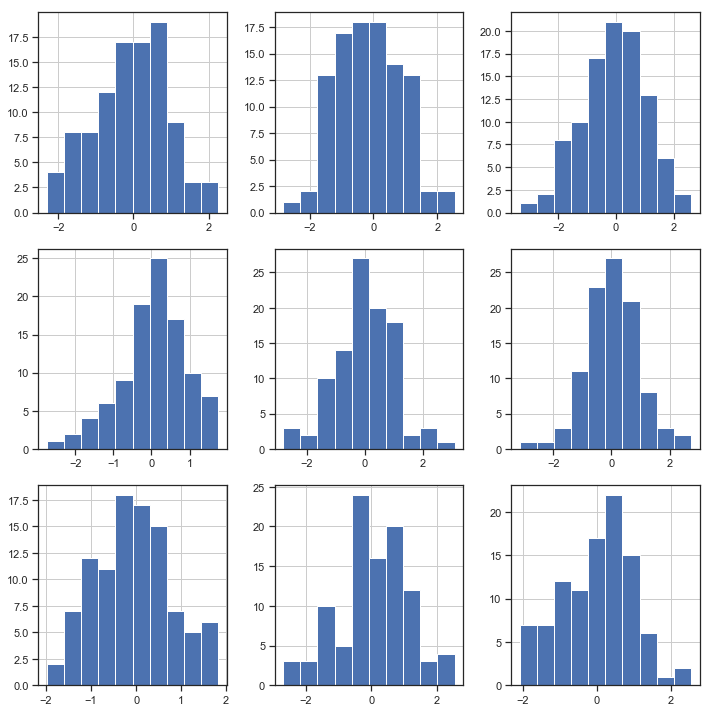

In [ ]:
plt.figure(figsize=(10,10))
for i,z_t in enumerate(z_tests):
    z_t = z_t.detach().cpu().numpy()
    
    plt.subplot(3,3,i+1)
    
    plt.hist(z_t.flatten())
    plt.grid()
    
    plt.tight_layout()
    #print(z_t[0].flatten())

## Show first 9 selected images

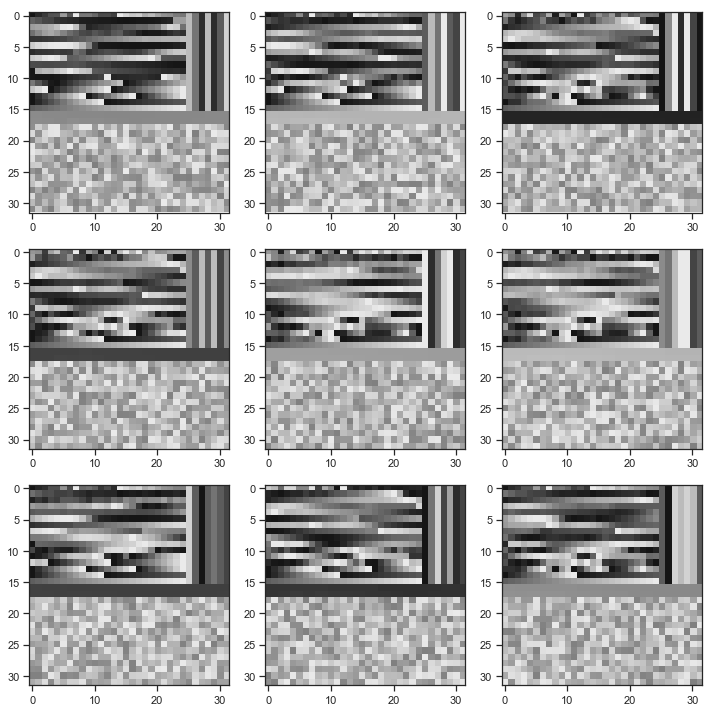

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    try:
        img = images[i]
        plt.subplot(3,3,i+1)
        plt.imshow(img[0, :, :], cmap='gray', vmin=-1.2, vmax=1.2)
    except:
        pass

plt.tight_layout()

In [ ]:
img.min(), img.max(), img.mean(), img.std()

(-1.0, 1.0, 0.20915326, 0.5578279)

# Visualizing the weights for debugging purposes

Layer: 0 	 n_weights: 512 	 std: 0.0550 	 mean: -0.0005
Layer: 1 	 n_weights: 16384 	 std: 0.3833 	 mean: -0.0078
Layer: 2 	 n_weights: 32768 	 std: 0.4126 	 mean: 0.0361
Layer: 3 	 n_weights: 131072 	 std: 0.4885 	 mean: 0.0340
Layer: 4 	 n_weights: 524288 	 std: 0.1568 	 mean: 0.0020
Layer: 5 	 n_weights: 256 	 std: 0.0069 	 mean: -0.0007


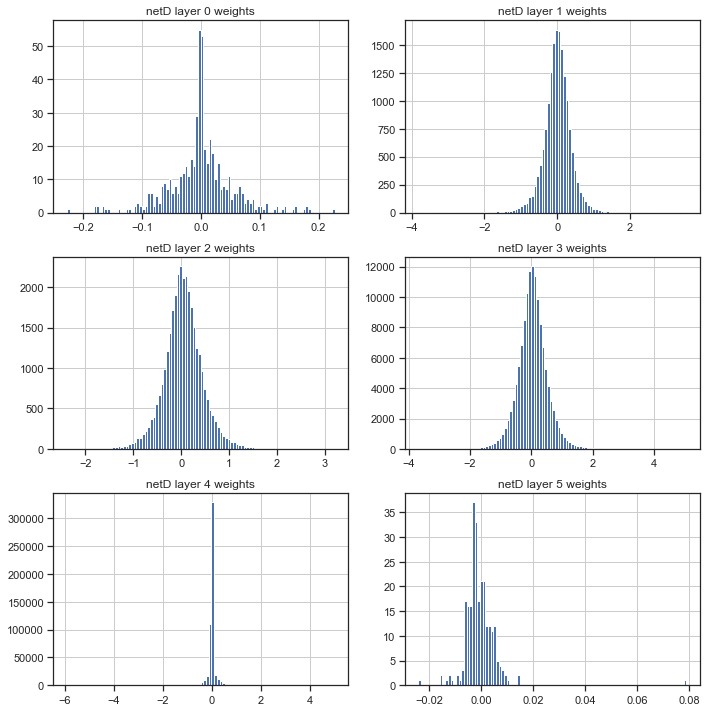

In [ ]:
weights = [param.data.cpu().numpy().flatten() for param in netD.parameters()]

plt.figure(figsize=(10,10))
for i,layer_weights in enumerate(weights):
    print('Layer: %s \t n_weights: %s \t std: %.4f \t mean: %.4f' % (i, len(layer_weights), layer_weights.std(), layer_weights.mean()))
    plt.subplot(3,2,i+1)
    plt.title('netD layer %s weights' % i)
    plt.hist(layer_weights, bins=100)
    plt.grid()
    plt.tight_layout()

Layer: 0 	 n_weights: 409600 	 std: 0.0962 	 mean: -0.0003
Layer: 1 	 n_weights: 524288 	 std: 0.1213 	 mean: -0.0090
Layer: 2 	 n_weights: 131072 	 std: 0.1181 	 mean: -0.0080
Layer: 3 	 n_weights: 32768 	 std: 0.0976 	 mean: -0.0106
Layer: 4 	 n_weights: 16384 	 std: 0.0826 	 mean: -0.0013
Layer: 5 	 n_weights: 512 	 std: 0.0316 	 mean: 0.0001


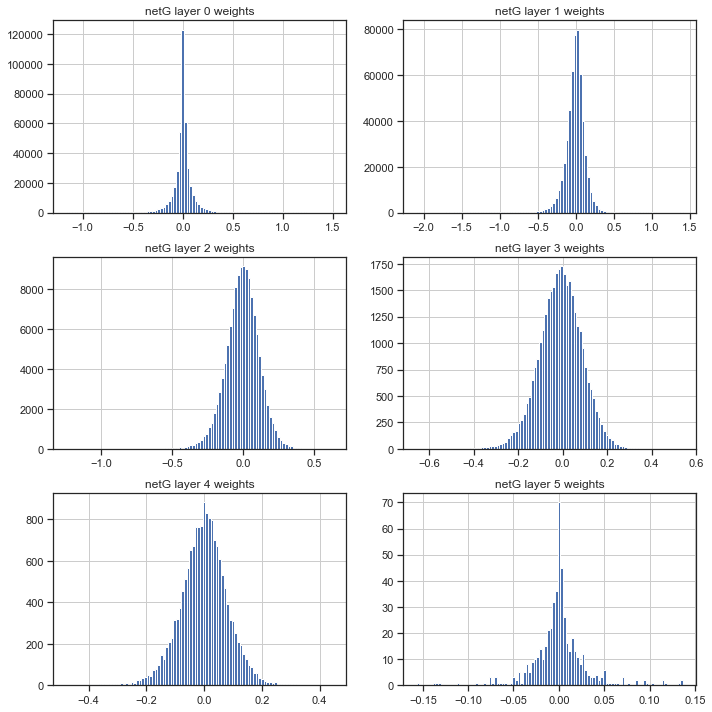

In [ ]:
weights = [param.data.cpu().numpy().flatten() for param in netG.parameters()] # where param.data are the weights of the i-th layer

plt.figure(figsize=(10,10))
for i,layer_weights in enumerate(weights):
    print('Layer: %s \t n_weights: %s \t std: %.4f \t mean: %.4f' % (i, len(layer_weights), layer_weights.std(), layer_weights.mean()))
    plt.subplot(3,2,i+1)
    plt.title('netG layer %s weights' % i)
    plt.hist(layer_weights, bins=100)
    plt.grid()
    plt.tight_layout()

# Inpainting
The corrupted image $y$ is mapped to the closest $z$ in the latent representation space, this mapping is denoted as $\hat{z}$.
    
$\hat{z} = \operatorname{arg\,min}_z \{ \mathcal{L}_c(z |y, M) + \mathcal{L}_p (z) \}$

where

$\mathcal{L}_c(z |y, M) = || M \bigodot G(z) - M \bigodot y||_1 = || M \bigodot (G(z)-y) ||_1 $

with $\mathcal{L}_c$ being contextual loss and $M$ being a binary mask with the same size as $y$,

$\mathcal{L}_p (z) = \lambda \operatorname{log}(1-D(G(z)))$

with $\mathcal{L}_p$ being perceptual loss and $D$ being the discriminator.
  
Once $G(\hat{z})$ is generated, the final solution $\hat{x}$ is calculated as

$\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$  

(substitute $x_i = y_i$ for $M_i = 1$).

-----

$|| ... ||$ is done by `torch.norm()`.  
$... \bigodot ...$ is done by `torch.mul()`.  
-----
TODO: Implement $\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$    
Currently $\hat{x} = G(\hat{z}) \bigodot (1 -M)+y$

In [ ]:
ind = pd.read_csv('wavelengths_and_indices.csv')  # where x is the wavelength

ind[(ind.x > 10) & (ind.x <= 14)]

,Unnamed: 0,x
129,129,13.900046
130,130,13.762421
131,131,13.626160
132,132,13.491247
133,133,13.357671
134,134,13.225416
135,135,13.094472
136,136,12.964823
137,137,12.836459
138,138,12.709365


In [ ]:
def create_mask():
    
    mask = np.full([1,1,32,32], 1) # init array with 0.5's
    mask = torch.from_numpy(mask).to(device)
    
    #mask = torch.ones([1, 1, 32, 32]).to(device) # create mask with 1's in the shape of image
    
    #print("mask.shape", mask.shape)

    # use a random 'easy' mask
    
    # set all params to 0
    mask[:, :, :16, 25:] = 0
    
    # set noise to 0
    mask[:, :, 18:, :] = 0
    
    
    """Weighted mask"""
    # Normalization factors
    mask[:, :, 16:18, :] = 6  #6
    
    # Planet mass
    mask[:, :, :16, 25:26] = 0
    
    mask = mask.float() # make sure dtype is float, torch was complaining during inpainting that this is a double
    
    return mask

## Visualize the mask

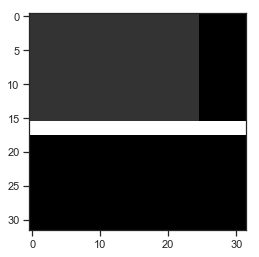

In [ ]:
m = create_mask().cpu()[0, 0, :, :]
plt.imshow(m, cmap='gray', vmin=0, vmax=5) 

In [ ]:
t = m.cpu().numpy().flatten()

for i in range(len(t)):
    if np.isnan(t[i]):
        print('nan')

In [ ]:
# Lists to keep track of progress
real_images = []
masked_images= []
inpainted_images = []
final_inpainted_images = [] # last inpainted image for each input image
n_iteration = []

MSELoss = nn.MSELoss()
L1Loss = nn.L1Loss() # MAE
SmoothL1Loss = nn.SmoothL1Loss()

"""
Inpainting
"""
for i, data in enumerate(dataloader, 0): # batches per epoch
    real_cpu = data.to(device)
    b_size = real_cpu.size(0) # this is one ofc, it's one image we're trying to inpaint

    #print("data.shape: ", data.shape)
    image = data.to(device) # select the image (Channel, Height, Width), this is the original unmasked input image
    
    real_images.append(image)
    #print("image.shape: ", image.shape)

    """Mask the image"""
    mask = create_mask()

    masked_image = torch.mul(image, mask).to(device) #image bigodot mask
    masked_images.append(masked_image)
    #print('masked image shape', masked_image.shape)
    #plt.imshow(masked_image.detach().cpu()[0, 0, :, :], cmap='gray') # plot the masked image

    opt = optim.Adam([z], lr=lr)

    # what's v and m?
    v = torch.tensor(0, dtype=torch.float32, device=device)
    m = torch.tensor(0, dtype=torch.float32, device=device)


    """Start the inpainting process"""
    early_stopping_n_iters = 0
    early_stopping_min_loss = 999999 # set to random high number to initialize
    for iteration in range(n_iters):
        t1 = time.time()
        if z.grad is not None:
            z.grad.data.zero_()

        G.zero_grad()
        D.zero_grad()


        image_generated = G(z) # generated image G(z)
        image_generated_masked = torch.mul(image_generated, mask) # G(z) bigodot M
        image_generated_inpainted = torch.mul(image_generated, (1-mask))+masked_image
        
        if (iteration % 100 == 0):
            inpainted_images.append(image_generated_inpainted)

        #print("image_generated_inpainted.shape : ",image_generated_inpainted.shape)

        t = image_generated_inpainted.detach().cpu()[0, 0, :, :]

        # TODO: why does this already look real?
        #plt.imshow(t, cmap='gray') # plot the masked image 

        """Calculate losses"""
        loss_context = 10*torch.norm(image_generated_masked-masked_image, p=1) #what's p=1?
        #loss_context = lamb1*MSELoss(image_generated_masked,masked_image)
        #loss_context = L1Loss(image_generated_masked, masked_image)*10
        #loss_context = SmoothL1Loss(image_generated_masked, masked_image)*10
        
        discriminator_output = netD(image_generated_inpainted) - 0.005 # -0.005 offset so loss_perceptual doesn't become 1 when D(G(z)) == 1.000000
        #print("Discriminator output: ", discriminator_output)

        labels = torch.full((b_size,), 1, device=device)
        loss_perceptual = lamb2*torch.log(1-discriminator_output)
        
        #if loss_perceptual == -np.inf:
        #    #print('loss perceptual == -np.inf()')
        #    loss_perceptual = torch.tensor(-10, dtype=torch.float32, device=device)
        
        #print(loss_perceptual.data.cpu().numpy().flatten()[0])

        total_loss = loss_context + loss_perceptual
        #total_loss = loss_context + 10*discriminator_output
        
        # grab the values from losses for printing
        loss_perceptual = loss_perceptual.data.cpu().numpy().flatten()[0]
        #loss_perceptual = 0
        loss_context = loss_context.data.cpu().numpy().flatten()[0]



        total_loss.backward()
        opt.step()
        
        total_loss = total_loss.data.cpu().numpy().flatten()[0]
        
        """Early stopping""" # TODO: 
        if iteration > 0:
            delta_loss = early_stopping_min_loss - total_loss
            delta_iters = iteration - iter1
            
            if (delta_loss < 0.1) or (total_loss > early_stopping_min_loss):
                early_stopping_n_iters += 1
            else:
                #print('set to zero')
                early_stopping_n_iters = 0
            
            if early_stopping_n_iters > 1000:
                n_iteration.append(iteration)
                break
            
        loss1 = total_loss
        iter1 = iteration
        
        if total_loss < early_stopping_min_loss:
            early_stopping_min_loss = total_loss
            best_inpained_image = image_generated_inpainted.detach().cpu()
            early_stopping_n_iters = 0
            #print('min loss: ', early_stopping_min_loss)
         
        t2 = time.time()
        
        """Calculate ETA"""
        t_per_iter = t2 - t1 # time per iteration in seconds
        
        eta = t_per_iter * (n_iters - iteration) + t_per_iter* (len(images)-i+1) * n_iters # time left to finish epoch/image + time left to finish all epochs/images in SECONDS
        eta_h = (eta/ 60) // 60 # divisor integer
        eta_m = eta % 60 # get remainer
        
        if (iteration % 50 == 0):
            print("\r image [{}/{}] iteration : {:4} , context_loss: {:.3f}, perceptual_loss: {:3f}, total_loss: {:3f}, min L: {:3f}, {:1f}, D(G(z)): {:3f}, ETA: {:.0f}h {:.0f}m".format(i+1, 
            len(images), iteration, loss_context,loss_perceptual, total_loss,early_stopping_min_loss, early_stopping_n_iters, discriminator_output.data.cpu().numpy().flatten()[0], eta_h, eta_m),end="")
            

            
        """NaN monitor"""
        #if (loss_context or loss_perceptual == np.nan()) and iteration >64:
        #    print(r'='*10 + '     NaN     '+ '='*10)
        #    print(loss_context, loss_percept  ual)
            #break+
        
    final_inpainted_images.append(best_inpained_image.detach().cpu())

 image [2086/3000] iteration : 1300 , context_loss: 116.219, perceptual_loss: -0.670851, total_loss: 115.547836, min L: 97.979225, 85.000000, D(G(z)): 0.488727, ETA: 29h 0m

In [58]:
len(real_images)

3000

## Inverse transform ASPA to spectrum

In [59]:
def inverse_scale(X_, X_min, X_max):
    """
    X_ is scaled X
    X is unscaled X_
    """
    X = X_ * (X_max - X_min) + X_min
    return X

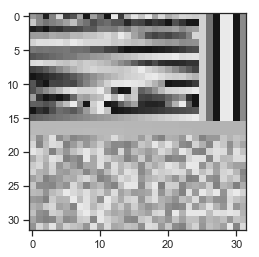

In [60]:
i = 0
aspa = real_images[i].detach().cpu().numpy()[0, 0, :, :]


plt.imshow(aspa, cmap='gray', vmin=-1.2, vmax=1.2)



n_bins = 8 # amount of bins the spectrum got scaled in
"""Image parts from the aspa, still encoded"""
spectrum = aspa[:16, :25]
mins_ = [aspa[16:17, i*4:i*4+4] for i in range(n_bins)]
stds_ = [aspa[17:18, i*4:i*4+4] for i in range(n_bins)]
maxs_ = [aspa[18:19, i*4:i*4+4] for i in range(n_bins)]

"""Decode to arrays"""
spectrum = spectrum.flatten()

mins_ = [inverse_scale(mins_[i].mean(), 0.005, 0.03) for i in range(n_bins)]
stds_ = [inverse_scale(stds_[i].mean(), 0.005, 0.03) for i in range(n_bins)]
maxs_ = [inverse_scale(maxs_[i].mean(), 1e-7, 1e-4) for i in range(n_bins)]

In [61]:
df = pd.read_csv('wavelengths_and_indices.csv', header=None, skiprows=[0], usecols=[1]) # load wavelengths
df.columns = ['x']
df = df.loc[df['x'] <= 16] # select only wavelengths <= 16
df['y'] = spectrum

df.head()

,x,y
115,15.977744,0.226822
116,15.819548,0.056323
117,15.662919,-0.885059
118,15.507841,0.037993
119,15.354298,0.825209


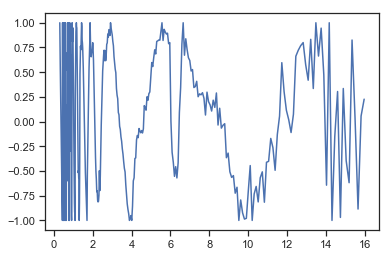

In [62]:
plt.plot(df.x, df.y)

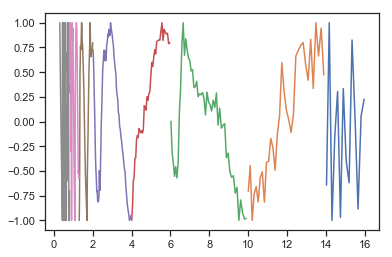

In [63]:
"""select spectrum bins"""
bin1 = df[df.x <= 0.8]
bin2 = df[(df.x > 0.8) & (df.x <= 1.3)] # select data between 2 and 4 micron
bin3 = df[(df.x > 1.3) & (df.x <= 2)]
bin4 = df[(df.x > 2) & (df.x <= 4)]
bin5 = df[(df.x > 4) & (df.x <= 6)]
bin6 = df[(df.x > 6) & (df.x <= 10)]
bin7 = df[(df.x > 10) & (df.x <= 14)]
bin8 = df[df.x > 14]

bins = [bin8, bin7, bin6, bin5, bin4, bin3, bin2, bin1]
for b in bins:
    plt.plot(b['x'], b['y'])

In [64]:
"""Inverse scale the bins"""
# min max values for spectrum from ASPA v2 notebook
min_values = [1.518400e+27, 
                  1.000000e+03, 
                  -1.842068e+01, 
                  5.592880e+07, 
                  -1.842068e+01, 
                  -1.842068e+01, 
                  -1.842068e+01]
    
max_values = [3.796000e+27, 
                  2.000000e+03, 
                  -2.302585e+00, 
                  1.048665e+08, 
                  -2.302585e+00, 
                  -2.302585e+00,
                  -2.302585e+00]

spectra_inverses = []
for i in range(7):
    bin_ = bins[i]
    max_ = maxs_[i]
    min_ = mins_[i]
    
    spectrum = bin_['y']
    spectrum_inverse = inverse_scale(spectrum, min_values[i], max_values[i])
    spectra_inverses.append(spectrum_inverse)

spectra_inverses

[115    2.035010e+27
 116    1.646682e+27
 117   -4.974113e+26
 118    1.604934e+27
 119    3.397895e+27
 120    1.100198e+26
 121    6.184170e+26
 122    2.280696e+27
 123   -6.901209e+26
 124    2.211230e+27
 125    1.175693e+27
 126   -7.592000e+26
 127    3.796000e+27
 128    5.289198e+25
 Name: y, dtype: float32, 129    1471.962524
 130    1945.637695
 131    1663.008179
 132    2000.000000
 133    1334.564575
 134    1831.986816
 135    1418.653320
 136    1577.347412
 137    1799.298828
 138    1768.280396
 139    1721.421143
 140    1661.185791
 141    1075.113281
 142     889.386108
 143    1018.650330
 144    1113.816162
 145    1301.751099
 146    1596.029541
 147    1055.855225
 148     869.618103
 149     507.088104
 150     736.426575
 151     829.547485
 152     597.996582
 153     588.010742
 154     184.107910
 155     491.299164
 156     431.451660
 157     187.164307
 158     343.950317
 159     267.367371
 160       0.000000
 161     554.856445
 162     294.873962
 

# Show results

In [65]:
real = real_images[0].detach().cpu()[0, 0, :, :]
real_masked = masked_images[0].detach().cpu()[0, 0, :, :]

#first_generated =inpainted_images[1].detach().cpu()[0, 0, :, :]
last_generated = inpainted_images[-1].detach().cpu()[0, 0, :, :]

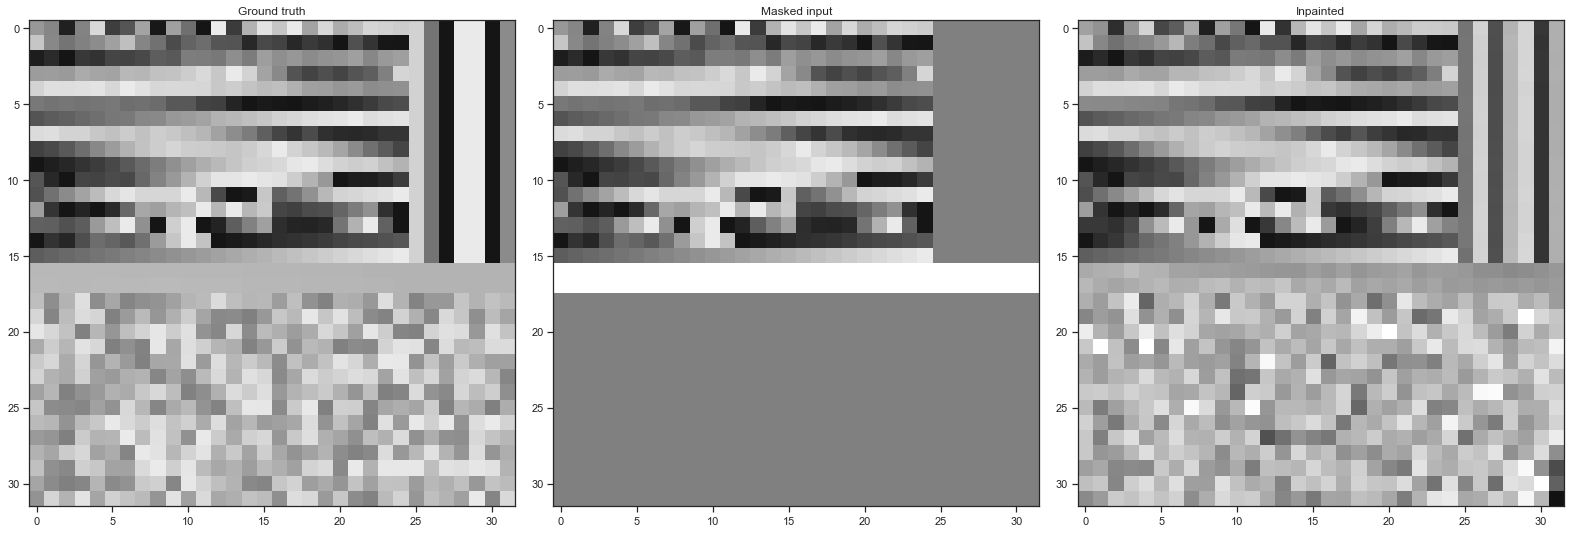

In [66]:
plt.figure(figsize=(22,10))

plt.subplot(1,3,1)
plt.imshow(real, cmap='gray', vmin=-1.2, vmax=1.2)
plt.title('Ground truth')

plt.subplot(1,3,2)
plt.imshow(real_masked, cmap='gray', vmin=-1.2, vmax=1.2)
plt.title('Masked input')

plt.subplot(1,3,3)
plt.imshow(last_generated, cmap='gray', vmin=-1.2, vmax=1.2)
plt.title('Inpainted')

plt.tight_layout()

#plt.savefig('plots/inpainting.png', dpi=1300)

mean: -0.0034 
 std: 0.2167 
 min: -1.0210 
 max: 0.9054


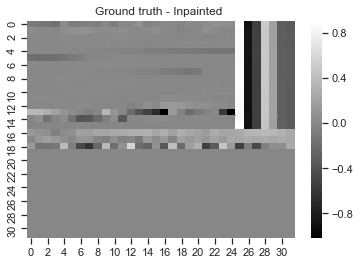

In [67]:
difference = real - last_generated
difference[19:, :] = 0 # remove the noise, it doesn't matter

#sns.heatmap(difference, cmap='gray', vmin=-2, vmax=2)
sns.heatmap(difference, cmap='gray')
plt.title('Ground truth - Inpainted ')

difference  = difference.cpu().detach().numpy().flatten()

mean, sigma, min_, max_ = difference.mean().item(), difference.std(), difference.min(), difference.max()
print('mean: %.4f \n std: %.4f \n min: %.4f \n max: %.4f' % (mean, sigma, min_, max_))

# Decoding ASPA
Need to clean this up. Using dicts like this is not clean.

In [68]:
aspa_inpainted = last_generated.numpy()
aspa_real = real.numpy()

aspa_inpainted.shape

(32, 32)

In [69]:
# Initialize ExoGAN params with zero's
inpainted_params = {
    'planet_mass': 0,
    'temp_profile': 0,
    'ch4_mixratio': 0,
    'planet_radius': 0,
    'h2o_mixratio': 0,
    'co2_mixratio': 0,
    'co_mixratio': 0
}

real_params = inpainted_params.copy()
params_errors = inpainted_params.copy()

## Inverse scale functions

In [70]:
def inverse_scale_param(X_scaled, X_min, X_max):
    return (X_scaled * (X_max-X_min)) + X_min

def inverse_scale_params(params):
    """
    Inverse scales the params array. 
    Params must be in fixed order, same order as it is encoded with.
    """
    params = params.copy()
    min_values = [1.518400e+27, 
                  1.000000e+03, 
                  -1.842068e+01, 
                  5.592880e+07, 
                  -1.842068e+01, 
                  -1.842068e+01, 
                  -1.842068e+01]
    
    max_values = [3.796000e+27, 
                  2.000000e+03, 
                  -2.302585e+00, 
                  1.048665e+08, 
                  -2.302585e+00, 
                  -2.302585e+00,
                  -2.302585e+00]

    params_inverse_scaled = []
    for i in range(len(params)):
        param = params[i]
        min_= min_values[i]
        max_ = max_values[i]

        params_inverse_scaled.append(inverse_scale_param(param, min_, max_))
    
    return params_inverse_scaled

## Inpainted params

In [71]:
inpainted_params_values = [aspa_inpainted[:16, 25+i:26+i] for i in range(len(inpainted_params))]
inpainted_params_mean  = [i.mean() for i in inpainted_params_values]

inpainted_params_mean

[-0.09824403,
 0.7703146,
 -0.46483964,
 0.50989294,
 0.8014951,
 -0.6986293,
 0.44100067]

In [72]:
y = (0.5876265 * (-2.306--1.842068e+01))+-1.842068e+01
y

-8.95126699298

In [73]:
inpainted_params_mean = inverse_scale_params(inpainted_params_mean)
inpainted_params_mean

[1.294639405691624e+27,
 1770.3145742416382,
 -25.91300943343669,
 80881787.7553463,
 -5.502106235477925,
 -29.68125374419123,
 -11.312589302739353]

### Convert mixtures from log back to regular scale

In [74]:
for i,param in enumerate(inpainted_params):
    if 'mixratio' in param:
        inpainted_params[param] = (inpainted_params_mean[i]) # convert log back to regular scale
    else:
        inpainted_params[param] = inpainted_params_mean[i]

In [75]:
inpainted_params

{'ch4_mixratio': -25.91300943343669,
 'co2_mixratio': -29.68125374419123,
 'co_mixratio': -11.312589302739353,
 'h2o_mixratio': -5.502106235477925,
 'planet_mass': 1.294639405691624e+27,
 'planet_radius': 80881787.7553463,
 'temp_profile': 1770.3145742416382}

## Real params
Ground truth params

In [76]:
real_params_values = [aspa_real[:16, 25+i:26+i] for i in range(len(real_params))]
real_params_mean  = [i.mean() for i in real_params_values]
real_params_mean

[0.7777778, -0.11111111, -1.0000001, 1.0, 1.0, -1.0000001, 0.11111107]

In [77]:
real_params_mean = inverse_scale_params(real_params_mean)
real_params_mean

[3.289866696834564e+27,
 888.8888880610466,
 -34.53877692142666,
 104866500.0,
 -2.3025850000000005,
 -34.53877692142666,
 -16.62978126274731]

### Convert mixtures from log back to regular scale

In [78]:
for i,param in enumerate(real_params):
    if 'mixratio' in param:
        real_params[param] = (real_params_mean[i]) # convert log back to regular scale
    else:
        real_params[param] = real_params_mean[i]

In [79]:
real_params

{'ch4_mixratio': -34.53877692142666,
 'co2_mixratio': -34.53877692142666,
 'co_mixratio': -16.62978126274731,
 'h2o_mixratio': -2.3025850000000005,
 'planet_mass': 3.289866696834564e+27,
 'planet_radius': 104866500.0,
 'temp_profile': 888.8888880610466}

## Percentage error

% error = $\frac{y-\hat{y}}{\hat{y}} \cdot$ 100

In [80]:
percentage_errors = []
for param in real_params:
    y_hat = real_params[param]
    y = inpainted_params[param]
    
    params_errors[param] = ((y - y_hat) / y_hat)*100

params_errors

{'ch4_mixratio': -24.974154434052473,
 'co2_mixratio': -14.063969862876036,
 'co_mixratio': -31.97391400402302,
 'h2o_mixratio': 138.9534473419189,
 'planet_mass': -60.647663720317404,
 'planet_radius': -22.871662775675457,
 'temp_profile': 99.16038978766686}

## Print results

In [81]:
for param in inpainted_params:
    real = real_params[param]
    inpainted = inpainted_params[param]
    error = params_errors[param]
    
    print('%s \t Real value: %.5e \t inpainted value: %.5e \t perc. diff.: %.25f' % (param, real, inpainted, error))

planet_mass 	 Real value: 3.28987e+27 	 inpainted value: 1.29464e+27 	 perc. diff.: -60.6476637203174036017117032
temp_profile 	 Real value: 8.88889e+02 	 inpainted value: 1.77031e+03 	 perc. diff.: 99.1603897876668582966885879
ch4_mixratio 	 Real value: -3.45388e+01 	 inpainted value: -2.59130e+01 	 perc. diff.: -24.9741544340524725953400775
planet_radius 	 Real value: 1.04866e+08 	 inpainted value: 8.08818e+07 	 perc. diff.: -22.8716627756754569134045596
h2o_mixratio 	 Real value: -2.30259e+00 	 inpainted value: -5.50211e+00 	 perc. diff.: 138.9534473419188884690811392
co2_mixratio 	 Real value: -3.45388e+01 	 inpainted value: -2.96813e+01 	 perc. diff.: -14.0639698628760356768907513
co_mixratio 	 Real value: -1.66298e+01 	 inpainted value: -1.13126e+01 	 perc. diff.: -31.9739140040230189754311141


# Functionize this to output the MAPE of all inpainted images per metric 

In [82]:
#real_images = []
#final_inpainted_images = []

reals = []
inpainteds = []
errors = []
for i in range(len(real_images)-1):
    aspa_real = real_images[i].detach().cpu()[0, 0, :, :].numpy() # size is 32,32 now
    aspa_inpainted = final_inpainted_images[i].detach().cpu()[0, 0, :, :].numpy() # size is 32,32 now

    """Decode inpainted aspa"""
    inpainted_params_values = [aspa_inpainted[:16, 25+j:26+j] for j in range(len(inpainted_params))]
    inpainted_params_mean  = [k.mean() for k in inpainted_params_values]
    inpainted_params_mean = inverse_scale_params(inpainted_params_mean)
    
    for a,param in enumerate(inpainted_params):
        if 'mixratio' in param:
            inpainted_params[param] = inpainted_params_mean[a] # convert log back to regular scale
        else:
            inpainted_params[param] = inpainted_params_mean[a]
    
    """Decode real aspa"""
    real_params_values = [aspa_real[:16, 25+b:26+b] for b in range(len(real_params))]
    real_params_mean  = [c.mean() for c in real_params_values]
    real_params_mean = inverse_scale_params(real_params_mean)
    
    for d,param in enumerate(real_params):
        if 'mixratio' in param:
            real_params[param] = real_params_mean[d] # convert log back to regular scale
        else:
            real_params[param] = real_params_mean[d]

    """Calculate percentage difference"""
    params_errors = dict.fromkeys(params_errors, 0) # copy dicts' keys, set all values to zero
    for param in real_params:
        y_hat = real_params[param]
        y = inpainted_params[param]
        
        params_errors[param] = ((y - y_hat) / y_hat)*100

    reals.append(real_params.copy()) # !!!!! for some reason dicts need to be copied, to be able to append to a list... otherwise the dicts inside the lists get update too
    inpainteds.append(inpainted_params.copy())
    errors.append(params_errors.copy())


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


# Create one large df from all the dicts

In [83]:
dfs = []
for i in range(len(errors)):
    print(reals[i])
    df1 = pd.DataFrame(errors[i], index=[0])
    df1.columns = [i+'_error' for i in df1.columns]

    df2 = pd.DataFrame(reals[i], index=[0])
    df2.columns = [i+'_real' for i in df2.columns]

    df3 = pd.DataFrame(inpainteds[i], index=[0])
    df3.columns = [i+'_inpainted' for i in df3.columns]

    df = pd.concat([df1, df2, df3], axis=1)
    
    dfs.append(df)

df = pd.concat(dfs)

{'planet_mass': 3.289866696834564e+27, 'temp_profile': 888.8888880610466, 'ch4_mixratio': -34.53877692142666, 'planet_radius': 104866500.0, 'h2o_mixratio': -2.3025850000000005, 'co2_mixratio': -34.53877692142666, 'co_mixratio': -16.62978126274731}
{'planet_mass': 2.783733393669128e+27, 'temp_profile': 444.4444179534912, 'ch4_mixratio': -23.79337945416555, 'planet_radius': 17866143.796241283, 'h2o_mixratio': -13.047982467261107, 'co2_mixratio': -27.375178609919253, 'co_mixratio': -2.3025850000000005}
{'planet_mass': 2.783733393669128e+27, 'temp_profile': 1555.5555820465088, 'ch4_mixratio': -27.375178609919253, 'planet_radius': 6991100.0, 'h2o_mixratio': -16.62978126274731, 'co2_mixratio': -13.047982467261107, 'co_mixratio': -20.211580298411846}
{'planet_mass': 3.289866696834564e+27, 'temp_profile': 1555.5555820465088, 'ch4_mixratio': -2.3025850000000005, 'planet_radius': 50491277.73726508, 'h2o_mixratio': -9.466183311507404, 'co2_mixratio': -23.79337945416555, 'co_mixratio': -34.5387769

# Errors of all images

In [84]:
df.describe()

,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,ch4_mixratio_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2.999000e+03,2999.000000,2999.000000,...,2999.000000,2999.000000,2999.000000,2.999000e+03,2999.000000,2999.000000,2.999000e+03,2999.000000,2999.000000,2999.000000
mean,-36.565768,NaN,5.790602,-5.681730,18.725311,5.181104,21.211135,1.563377e+27,987.736653,-18.495327,...,-18.188384,-18.556238,-18.446359,1.871681e+27,1076.630718,-18.150077,5.348007e+07,-18.145564,-18.198371,-17.722427
std,375.571108,NaN,30.028403,17.962188,78.057769,27.505077,126.499496,1.457062e+27,643.823522,10.281891,...,10.281201,10.375732,10.013937,1.246268e+27,545.157222,9.340582,3.090586e+07,9.055376,9.596417,8.875547
min,-1748.093790,-inf,-87.556584,-158.870792,-63.650883,-84.701216,-115.321152,-7.592000e+26,0.000000,-34.538777,...,-34.538777,-34.538777,-34.538777,-1.477787e+27,-529.152989,-34.618629,-4.115716e+06,-36.190516,-35.095833,-38.909898
25%,-88.616370,-36.856586,-4.426309,-10.964130,-5.599880,-5.670957,-22.207327,2.530666e+26,444.444418,-27.375179,...,-27.375179,-27.375179,-27.375179,1.012782e+27,645.509571,-26.880213,2.471285e+07,-26.700422,-27.235683,-25.225353
50%,-18.901691,10.148609,-0.427134,-4.521198,-1.243915,-1.279425,-2.943739,1.771467e+27,888.888888,-16.629781,...,-16.629781,-20.211580,-20.211580,2.018589e+27,1069.292009,-18.633244,5.446849e+07,-18.333449,-18.642607,-18.127138
75%,53.047090,139.476829,5.558858,-0.791500,4.916987,6.445972,22.291179,2.783733e+27,1555.555582,-9.466183,...,-9.466183,-9.466183,-9.466183,2.892242e+27,1560.743243,-9.631558,8.077631e+07,-9.455476,-9.695390,-9.696077
max,1443.932484,inf,276.540208,130.441862,1471.734202,222.823441,1403.999925,3.796000e+27,2000.000000,-2.302585,...,-2.302585,-2.302585,-2.302585,4.715533e+27,2397.862315,-2.015118,1.166746e+08,-5.037622,-1.563053,4.194193


In [85]:
df.describe()

,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,ch4_mixratio_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2.999000e+03,2999.000000,2999.000000,...,2999.000000,2999.000000,2999.000000,2.999000e+03,2999.000000,2999.000000,2.999000e+03,2999.000000,2999.000000,2999.000000
mean,-36.565768,NaN,5.790602,-5.681730,18.725311,5.181104,21.211135,1.563377e+27,987.736653,-18.495327,...,-18.188384,-18.556238,-18.446359,1.871681e+27,1076.630718,-18.150077,5.348007e+07,-18.145564,-18.198371,-17.722427
std,375.571108,NaN,30.028403,17.962188,78.057769,27.505077,126.499496,1.457062e+27,643.823522,10.281891,...,10.281201,10.375732,10.013937,1.246268e+27,545.157222,9.340582,3.090586e+07,9.055376,9.596417,8.875547
min,-1748.093790,-inf,-87.556584,-158.870792,-63.650883,-84.701216,-115.321152,-7.592000e+26,0.000000,-34.538777,...,-34.538777,-34.538777,-34.538777,-1.477787e+27,-529.152989,-34.618629,-4.115716e+06,-36.190516,-35.095833,-38.909898
25%,-88.616370,-36.856586,-4.426309,-10.964130,-5.599880,-5.670957,-22.207327,2.530666e+26,444.444418,-27.375179,...,-27.375179,-27.375179,-27.375179,1.012782e+27,645.509571,-26.880213,2.471285e+07,-26.700422,-27.235683,-25.225353
50%,-18.901691,10.148609,-0.427134,-4.521198,-1.243915,-1.279425,-2.943739,1.771467e+27,888.888888,-16.629781,...,-16.629781,-20.211580,-20.211580,2.018589e+27,1069.292009,-18.633244,5.446849e+07,-18.333449,-18.642607,-18.127138
75%,53.047090,139.476829,5.558858,-0.791500,4.916987,6.445972,22.291179,2.783733e+27,1555.555582,-9.466183,...,-9.466183,-9.466183,-9.466183,2.892242e+27,1560.743243,-9.631558,8.077631e+07,-9.455476,-9.695390,-9.696077
max,1443.932484,inf,276.540208,130.441862,1471.734202,222.823441,1403.999925,3.796000e+27,2000.000000,-2.302585,...,-2.302585,-2.302585,-2.302585,4.715533e+27,2397.862315,-2.015118,1.166746e+08,-5.037622,-1.563053,4.194193


In [86]:
params = [param for param in real_params.keys()]
param = params[2]
print(param)

ch4_mixratio


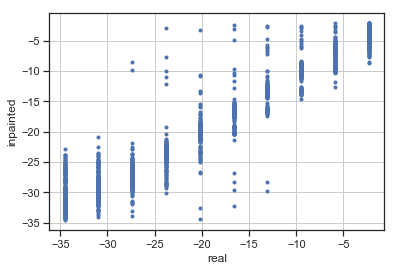

In [87]:
x = df[param+'_real']
y = df[param+'_inpainted']

plt.plot(x, y, '.')
plt.xlabel('real')
plt.ylabel('inpainted')
plt.grid()

In [88]:
x

0   -34.538777
0   -23.793379
0   -27.375179
0    -2.302585
0    -5.884385
0   -30.956977
0   -27.375179
0    -9.466183
0   -27.375179
0   -13.047982
0   -30.956977
0   -30.956977
0    -9.466183
0    -9.466183
0   -20.211580
0   -20.211580
0   -13.047982
0    -9.466183
0   -23.793379
0   -30.956977
0   -30.956977
0   -20.211580
0    -2.302585
0   -27.375179
0   -16.629781
0    -9.466183
0   -27.375179
0   -20.211580
0   -23.793379
0   -30.956977
       ...    
0    -2.302585
0   -27.375179
0    -5.884385
0   -20.211580
0   -23.793379
0   -13.047982
0   -20.211580
0   -34.538777
0    -9.466183
0    -2.302585
0   -30.956977
0   -20.211580
0   -27.375179
0    -9.466183
0    -9.466183
0   -16.629781
0    -5.884385
0    -2.302585
0   -16.629781
0   -16.629781
0    -9.466183
0   -34.538777
0   -27.375179
0    -2.302585
0    -5.884385
0   -13.047982
0   -13.047982
0    -5.884385
0   -16.629781
0    -2.302585
Name: ch4_mixratio_real, Length: 2999, dtype: float64

In [89]:
y

0   -29.053019
0   -23.570897
0   -27.026734
0    -2.466634
0    -7.432496
0   -30.865910
0   -23.584953
0    -9.599491
0   -27.492337
0   -12.912009
0   -27.969436
0   -31.269383
0    -9.629208
0    -9.254620
0   -22.638183
0   -20.313862
0   -12.966829
0   -10.381034
0   -22.531471
0   -30.467554
0   -29.617774
0   -19.090577
0    -2.233229
0   -26.716042
0   -15.828047
0   -10.211950
0   -27.358348
0   -19.409501
0   -23.458125
0   -30.273237
       ...    
0    -7.729911
0   -25.087086
0    -6.143869
0   -20.912937
0   -30.116008
0   -12.236194
0   -19.449540
0   -26.383453
0    -9.860978
0    -2.985603
0   -30.869352
0   -20.035074
0   -26.112165
0   -10.352089
0    -9.082856
0   -19.442130
0    -6.500962
0    -3.007420
0   -16.123827
0   -15.871771
0   -10.517605
0   -31.235484
0   -28.615899
0    -5.338723
0    -8.931576
0   -12.947502
0   -12.194946
0    -5.916335
0   -16.701613
0    -5.520659
Name: ch4_mixratio_inpainted, Length: 2999, dtype: float64

(array([2.400e+01, 1.650e+02, 2.461e+03, 2.210e+02, 4.900e+01, 2.400e+01,
        3.000e+01, 1.700e+01, 6.000e+00, 2.000e+00]),
 array([-87.55658404, -51.14690485, -14.73722566,  21.67245353,
         58.08213272,  94.49181191, 130.9014911 , 167.31117029,
        203.72084948, 240.13052867, 276.54020786]),
 <a list of 10 Patch objects>)

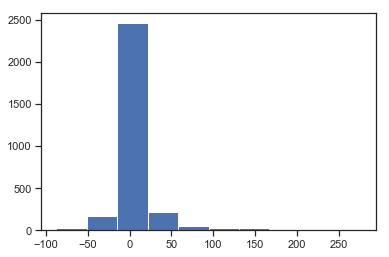

In [90]:
plt.hist(df[param+'_error'])

In [91]:
df.to_csv('Validation error of '+str(len(images))+' images')

In [92]:
df.head()

,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,ch4_mixratio_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
0,-27.067264,78.338515,-15.882895,-8.545976,149.951446,-5.627198,47.294869,3.289867e+27,888.888888,-34.538777,...,-2.302585,-34.538777,-16.629781,2.399390e+27,1585.231245,-29.053019,9.590463e+07,-5.755345,-32.595212,-24.494815
0,8.379777,109.309080,-0.935060,9.783388,0.732313,-2.399434,29.458702,2.783733e+27,444.444418,-23.793379,...,-13.047982,-27.375179,-2.302585,3.017004e+27,930.262521,-23.570897,1.961406e+07,-13.143535,-26.718329,-2.980897
0,-6.150364,-7.622564,-1.272850,-33.593059,-1.936941,-4.428362,-8.657057,2.783733e+27,1555.555582,-27.375179,...,-16.629781,-13.047982,-20.211580,2.612524e+27,1436.982363,-27.026734,4.642576e+06,-16.307672,-12.470171,-18.461852
0,-64.978869,11.050115,7.124579,-5.497482,6.899089,-3.083765,-20.175066,3.289867e+27,1555.555582,-2.302585,...,-9.466183,-23.793379,-34.538777,1.152149e+27,1727.446258,-2.466634,4.771553e+07,-10.119264,-23.059648,-27.570556
0,-30.767302,-7.528773,26.308812,-4.482115,-5.761838,15.129403,24.989892,1.265333e+27,1777.777791,-5.884385,...,-16.629781,-13.047982,-23.793379,8.760244e+26,1643.932939,-7.432496,4.822820e+07,-15.671600,-15.022064,-29.739319


In [93]:
print('DONE')

DONE


In [94]:
param = params[2]
df[[param+'_real', param+'_inpainted']]

,ch4_mixratio_real,ch4_mixratio_inpainted
0,-34.538777,-29.053019
0,-23.793379,-23.570897
0,-27.375179,-27.026734
0,-2.302585,-2.466634
0,-5.884385,-7.432496
0,-30.956977,-30.865910
0,-27.375179,-23.584953
0,-9.466183,-9.599491
0,-27.375179,-27.492337
0,-13.047982,-12.912009


In [95]:
print('Done')

Done


In [96]:
print('Done')

Done


In [97]:
print('done')

done


(6289.602341137123, 4832.953932026614)

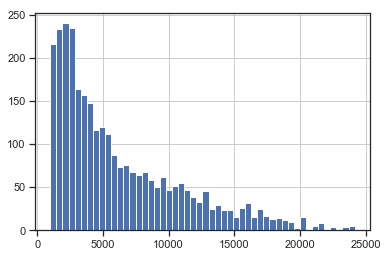

In [98]:
its = np.array(n_iteration)
plt.hist(its, bins=50)
plt.grid()

its.mean(), its.std()